Text(0.5, 1.0, 'Dynamics of Van Der Pol oscillator')

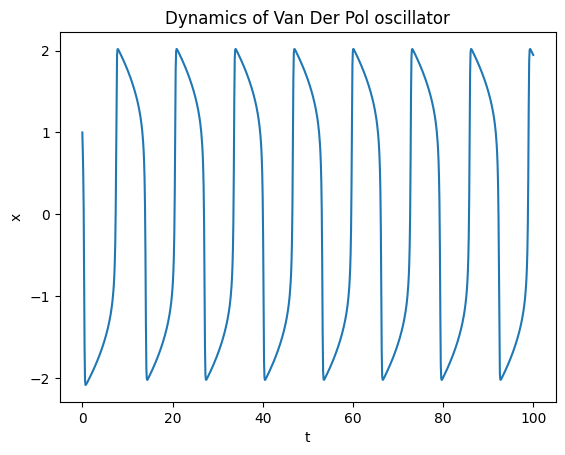

In [18]:
import numpy as np
import diffrax
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax.scipy.special import gammaln
from time import time
from jax import grad
import matplotlib.pyplot as plt
jax.config.update("jax_enable_x64", True)
tol = 1e-8
mu = 6.0
tf = 100
nn = tf*10+1
tSpan = jnp.linspace(0, tf, nn)
x = 1.0
y = 1.0
par = mu
IC = state = jnp.array([x,y])

def RHS(t,state,par):
    x,y = state
    mu = par
    return jnp.array([mu*(x - (x**3)/3.0 - y), x/mu])

terms = diffrax.ODETerm(RHS)
solver = diffrax.Dopri8()
t0 = tSpan[0]
t1 = tSpan[-1]
dt0 = None
y0 = state
saveat = diffrax.SaveAt(ts=tSpan)
stepsize_controller = diffrax.PIDController(rtol=tol, atol=tol)       
sol = diffrax.diffeqsolve(terms,solver,t0,t1,dt0,y0,args=(par),saveat=saveat,stepsize_controller=stepsize_controller,max_steps=int(1e12))
plt.plot(sol.ts,sol.ys[:,0])
plt.xlabel('t')
plt.ylabel('x')
plt.title('Dynamics of Van Der Pol oscillator')

In [19]:
def logL(par):
    terms = diffrax.ODETerm(RHS)
    solver = diffrax.Dopri8()
    t0 = tSpan[0]
    t1 = tSpan[-1]
    dt0 = None
    y0 = state
    saveat = diffrax.SaveAt(ts=tSpan)
    stepsize_controller = diffrax.PIDController(rtol=tol, atol=tol)       
    sol = diffrax.diffeqsolve(terms,solver,t0,t1,dt0,y0,args=(par),saveat=saveat,stepsize_controller=stepsize_controller,max_steps=int(1e12))
    return sol.ys[tt,0]    

xx = []
for tt in range(0,nn):
    xx.append(grad(logL)(par))

In [25]:
print('Sensitivity (by AD) of x(t = 98.0, 98.1, ..., 100.0) w.r.t. parameter \mu = \n' + str(np.asarray(xx[980:])))

Sensitivity (by AD) of x(t = 98.0, 98.1, ..., 100.0) w.r.t. parameter \mu = 
[ -4.80511179  -5.45124221  -6.32923707  -7.57459031  -9.43665654
 -12.40860131 -17.54801685 -27.30183766 -47.28710469 -83.51283474
 -91.67628984 -31.89802996  -4.79678672   0.25442481   1.0595868
   1.19626777   1.22907087   1.24566395   1.25993853   1.27416447
   1.28873726]


In [27]:
from scipy.integrate import solve_ivp
mu = 6.0
tf = 100
nn = tf*10+1
tSpan = np.linspace(0, tf, nn)
par = mu
x = 1.0
y = 1.0
IC = state = np.array([x,y])
stateDim, parDim = len(IC), 1

def F(t,state,par):
    x,y = state
    mu = par
    return np.array([mu*(x - (x**3)/3.0 - y), x/mu])
        
def J(t,state,par):
    x,y = state
    mu = par
    return np.array([[mu*(1-x**2), -mu],[1/mu, 0]])  
        
def dFdtheta_constant(t,state,par):
    x,y = state
    mu = par
    return np.array([[x - (x**3)/3.0 - y],[-x*(mu**(-2))]])
 
def jointF(t,jointState,par):

    x = jointState[:len(state)]
    s = jointState[len(state):].reshape((len(state),1))
    dx = F(t,x,par)
    ds = (J(t,x,par).dot(s)+ dFdtheta_constant(t,x,par)).reshape((len(state)*1,))
    return np.hstack((dx,ds))
    
stateDim = len(state)
nn = 1
jointState = np.zeros(stateDim*(nn+1))
jointState[:stateDim] = IC[:]
sol_buffer = solve_ivp(fun=lambda t,z: jointF(t,z,par), t_span=(tSpan[0],tSpan[-1]),y0=jointState, t_eval=tSpan, method='LSODA', rtol=tol,atol=tol)
yy = sol_buffer.y[2,0:]
print('Sensitivity (by forward) of x(t = 98.0, 98.1, ..., 100.0) w.r.t. parameter \mu = \n' + str(yy[980:]))

Sensitivity (by forward) of x(t = 98.0, 98.1, ..., 100.0) w.r.t. parameter \mu = 
[ -4.80511007  -5.45124047  -6.32923606  -7.57458566  -9.43664993
 -12.40858801 -17.54799221 -27.30178041 -47.28698747 -83.51268392
 -91.67649485 -31.89825642  -4.79684295   0.25441059   1.05958066
   1.19626757   1.22907051   1.24566399   1.25993868   1.27416461
   1.28873747]


Text(0, 0.5, 'Relative error between AD and forward')

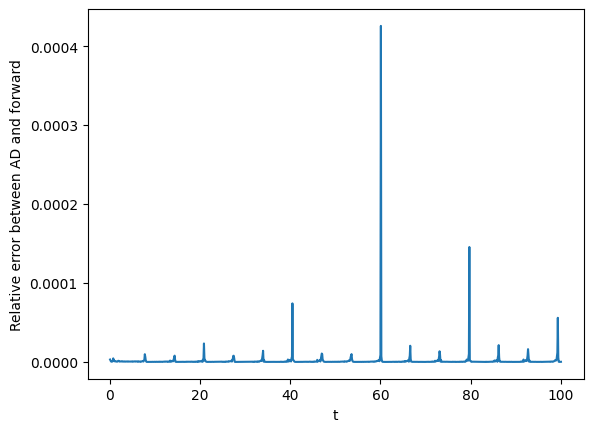

In [28]:
plt.plot(tSpan[1:],np.abs(1-xx[1:]/yy[1:]))
plt.xlabel('t')
plt.ylabel('Relative error between AD and forward')